# Stock Price Prediction with News Sentiment Analysis

## Comprehensive Analytical Notebook

## 1. Environment Setup & Validation

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import sys
import os

# Configure visualization
%matplotlib inline
sns.set_theme(style="whitegrid")  # Replace matplotlib style with seaborn theme
plt.rcParams['figure.figsize'] = [12, 6]

# Path configuration
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, os.pardir))
scripts_dir = os.path.join(project_root, 'scripts')

if os.path.exists(scripts_dir):
    sys.path.insert(0, scripts_dir)
    print(f"Success: Added {scripts_dir} to Python path")
else:
    raise FileNotFoundError(f"Missing scripts directory: {scripts_dir}")

# Verify stock_news.py
stock_news_path = os.path.join(scripts_dir, 'stock_news.py')
if not os.path.exists(stock_news_path):
    raise FileNotFoundError(f"Missing stock_news.py at {stock_news_path}")
else:
    print(f"Verified: Found stock_news.py")

# Environment check
print("\nPython version:", sys.version.split()[0])
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Seaborn version:", sns.__version__)

Success: Added d:\DataScienceBoiiii\Projects\project4_stock_prediction\scripts to Python path
Verified: Found stock_news.py

Python version: 3.12.5
Pandas version: 2.2.2
NumPy version: 2.1.0
Seaborn version: 0.13.2


## 2. Data Loading & Preparation

In [17]:
try:
    from stock_news import StockNewsAnalyzer
    import yfinance as yf
    
    analyzer = StockNewsAnalyzer("57a0a93396044df7ae44e6d72f084cfa")
    df = analyzer.process_data()
    
    # ===== Data Validation =====
    print("\nRaw Data Diagnostics:")
    print(f"Initial Rows: {len(df)}")
    print("Missing Values Before Cleaning:")
    print(df[['MA5', 'MA20', 'RSI']].isna().sum())
    
    # ===== Stock Data Verification =====
    print("\nNVDA Stock Data Check (Last 5 Trading Days):")
    nvda_check = yf.Ticker("NVDA").history(period="5d")
    display(nvda_check[['Close', 'Volume']])
    
    # ===== Date Alignment Check =====
    print("\nDate Alignment:")
    print(f"News Dates: {df['date'].min().date()} to {df['date'].max().date()}")
    print(f"Stock Dates: {df['date'].nunique()} unique dates")
    
    # ===== Clean Data =====
    df = df.dropna(subset=['MA5', 'MA20', 'RSI'])
    if df.empty:
        raise ValueError("""
        All technical indicators missing. Likely causes:
        1. News dates outside stock trading days
        2. Invalid stock ticker 'NVDA'
        3. Insufficient buffer in data collection
        """)
    
    print("\nClean Data Summary:")
    print(f"Final Rows: {len(df)}")
    print("Technical Indicator Ranges:")
    print(f"MA5: {df['MA5'].min():.2f} - {df['MA5'].max():.2f}")
    print(f"RSI: {df['RSI'].min():.2f} - {df['RSI'].max():.2f}")
    display(df.head(3))

except Exception as e:
    print(f"\n\033[1;31mCRITICAL ERROR:\033[0m {str(e)}")
    print("\nImmediate Actions:")
    print("1. Delete old data: rm data/processed_stock_data.csv")
    print("2. Manually verify stock data: yfinance.Ticker('NVDA').history(period='1mo')")
    print("3. Check news dates vs. trading days")
    raise

Starting data collection and processing...
Retrieved 87 news articles


[*********************100%***********************]  1 of 1 completed

Sentiment analysis completed
Retrieved stock data with 22 entries
Processed data saved to d:\DataScienceBoiiii\Projects\project4_stock_prediction\data\processed_stock_data.csv

Raw Data Diagnostics:
Initial Rows: 79
Missing Values Before Cleaning:
MA5     79
MA20    79
RSI     79
dtype: int64

NVDA Stock Data Check (Last 5 Trading Days):


,Close,Volume
Date,,
2025-01-23 00:00:00-05:00,147.220001,155915500
2025-01-24 00:00:00-05:00,142.619995,234657600
2025-01-27 00:00:00-05:00,118.419998,818830900
2025-01-28 00:00:00-05:00,128.990005,579666400
2025-01-29 00:00:00-05:00,123.699997,431674652



Date Alignment:
News Dates: 2024-12-30 to 2025-01-28
Stock Dates: 17 unique dates

CRITICAL ERROR: 
        All technical indicators missing. Likely causes:
        1. News dates outside stock trading days
        2. Invalid stock ticker 'NVDA'
        3. Insufficient buffer in data collection
        

Immediate Actions:
1. Delete old data: rm data/processed_stock_data.csv
2. Manually verify stock data: yfinance.Ticker('NVDA').history(period='1mo')
3. Check news dates vs. trading days


ValueError: 
        All technical indicators missing. Likely causes:
        1. News dates outside stock trading days
        2. Invalid stock ticker 'NVDA'
        3. Insufficient buffer in data collection
        

## 3. Exploratory Data Analysis


Summary Statistics:


,count,mean,min,25%,50%,75%,max,std
date,79.00,.2f,.2f,.2f,.2f,.2f,.2f,nan
sentiment_textblob,79.00,0.13,-0.80,0.00,0.00,0.28,0.80,0.24
sentiment_finbert,79.00,0.22,0.00,0.00,0.00,0.18,1.00,0.39
Close,79.00,136.47,118.42,133.23,140.11,140.14,149.43,7.86
Volume,79.00,330136391.14,155659200.00,204808900.00,234657600.00,351782200.00,818830900.00,194583308.42
MA5,0.00,nan,nan,nan,nan,nan,nan,nan
MA20,0.00,nan,nan,nan,nan,nan,nan,nan
RSI,0.00,nan,nan,nan,nan,nan,nan,nan
price_change,78.00,-0.04,-16.97,0.00,0.00,0.00,8.93,2.72
target,79.00,0.09,0.00,0.00,0.00,0.00,1.00,0.29



Missing Values:


,Missing Count
date,0
headline,0
sentiment_textblob,0
sentiment_finbert,0
Close,0
Volume,0
MA5,79
MA20,79
RSI,79
price_change,1


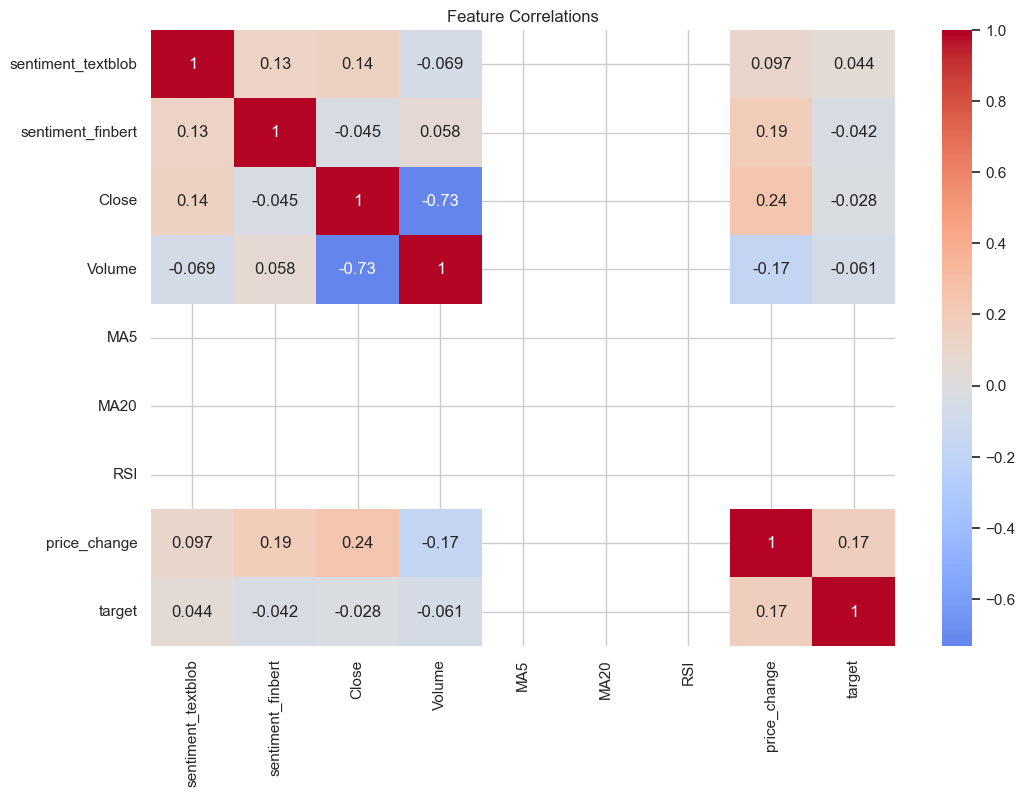

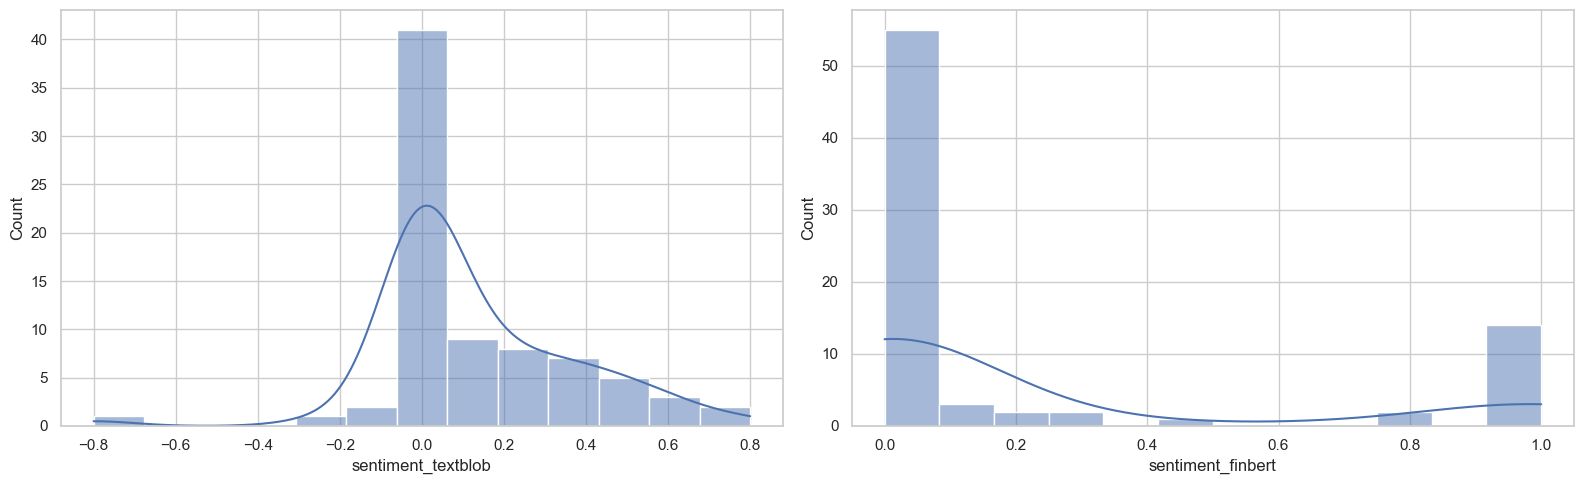

In [8]:
def perform_eda(df):
    # Basic stats
    print("\nSummary Statistics:")
    display(df.describe().T.style.format("{:.2f}"))
    
    # Missing values
    print("\nMissing Values:")
    display(df.isna().sum().to_frame('Missing Count'))
    
    # Correlation matrix (only numeric columns)
    plt.figure(figsize=(12, 8))
    numeric_df = df.select_dtypes(include=[np.number])
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlations')
    plt.show()
    
    # Sentiment distributions
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    sns.histplot(df['sentiment_textblob'], kde=True, ax=ax[0])
    sns.histplot(df['sentiment_finbert'], kde=True, ax=ax[1])
    plt.tight_layout()
    plt.show()

perform_eda(df)

## 4. Feature Engineering & Modeling

In [9]:
# Feature engineering
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
ml_df = df.dropna().copy()

# Feature selection
features = ['sentiment_textblob', 'sentiment_finbert', 'Volume', 'MA5', 'MA20', 'RSI']
X = ml_df[features]
y = ml_df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## 5. Model Training & Evaluation

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Evaluation
print("\nTraining Report:")
print(classification_report(y_train, train_preds))

print("\nTesting Report:")
print(classification_report(y_test, test_preds))

# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(confusion_matrix(y_train, train_preds), annot=True, fmt='d', ax=ax1)
sns.heatmap(confusion_matrix(y_test, test_preds), annot=True, fmt='d', ax=ax2)
plt.tight_layout()
plt.show()

## 6. Predictions & Insights

In [ ]:
# Latest prediction
latest_data = ml_df[features].iloc[-1:]
prediction = model.predict(latest_data)[0]
prob = model.predict_proba(latest_data)[0][prediction]

print(f"\nNext Day Prediction: {'↑ Bullish' if prediction else '↓ Bearish'}")
print(f"Confidence: {prob:.1%}")

# Feature importance
importance = pd.DataFrame({
    'Feature': features,
    'Impact': model.coef_[0]
}).sort_values('Impact', ascending=False)

print("\nFeature Impacts:")
display(importance.style.bar(align='zero', color=['#ff6961', '#77dd77']))